In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import koreanize_matplotlib
import json
import seaborn as sns

file = open('./input/data.json', 'r', encoding='utf-8')
data = json.load(file)

mpl.rcParams['font.family'] = 'Malgun Gothic'  # or 'MalgunGothic'
mpl.rcParams['axes.unicode_minus'] = False     # so minus signs render

In [2]:
q_key_value = {
    "사람과 있을 때 긴장을 많이 한다.": "사회적 긴장",
    "이유 없이 감정기복이 심하다.": "감정 기복",
    "심각하게 죄책감을 느낀다.": "과도한 죄책감",
    "예민하고 신경질이 난다.": "과민성/짜증",
    "자신감이 부족하다.": "낮은 자존감",
    "매사에 의욕이 없고 피곤하다.": "무기력/피로",
    "괜한 걱정을 미리한다.": "예기 불안",
    "사소한 일에도 불안해지거나 겁이 난다.": "과도한 불안",
    "자주 슬프거나, 기분이 가라앉거나, 우울해진다.": "우울 증상",
    "늦게 자서 아침에 일어나기 어렵다.": "수면 문제",
    "살고 싶지 않다는 생각이 자주 든다.": "자살 사고",
    "자해를 한 적이 있다.": "자해 행동",
    "자살계획을 구체적으로 세운 적이 있다.": "자살 계획",
    "자살을 심각하게 생각하고 있다.": "심각한 자살사고",
    "내 삶은 더 이상 희망이 없는 것 같다.": "절망감",
    "죽으려고 자살을 시도한 적이 있다.": "자살 시도",
    "거짓말을 자주 한다.": "빈번한 거짓말",
    "다른 아이들과 자주 다툰다(예: 말싸움 혹은 주먹 다툼).": "또래 갈등",
    "어른(부모, 교사 등)에게 반항적이거나 대든다.": "반항 행동",
    "다른 아이를 놀리거나 괴롭힌 적(언어폭력, 사이버폭력, 신체적폭력 등)이 있다.": "괴롭힘 가해",
    "이전에 겪었던 힘든 일들(사건·사고, 가까운 사람과의 이별 또는 사망 등)이 지금도 계속 생각나서 힘들다.": "외상 침습증상",
    "힘든 일들(사건·사고, 가까운 사람과의 이별 또는 사망 등)을 겪은 후 악몽을 자주 꾼다.": "외상 관련 악몽",
    "힘든 일들(사건·사고, 가까운 사람과의 이별 또는 사망 등)을 겪은 후 다른 사람을 믿기 어려워 혼자 지낸다.": "외상 후 고립",
    "힘든 일들(사건·사고, 가까운 사람과의 이별 또는 사망 등)을 겪은 후 지나치게 안전을 확인한다.": "외상 후 과각성",
    "힘든 일들(사건·사고, 가까운 사람과의 이별 또는 사망 등)이 생각나는 상황을 피한다.": "외상 회피행동",
    "담배를 자주 피우고 있다.": "흡연 문제",
    "술을 자주 마시고 있다.": "음주 문제",
    "적응력이나 대처 능력이 또래에 비해 떨어진다.": "적응력 저하",
    "집에서 멀리 떨어져 자는 것이 두렵다(수학여행, 캠프 등)": "분리 불안",
    "수업 내용을 대부분 이해하기 어렵다.": "학습 어려움",
    "다른 사람의 물건을 부수거나 훔친 적이 있다.": "재산 관련 비행",
    "게임에 너무 빠진 것 같다.": "게임 과몰입",
    "친구를 사귀거나 친밀한 관계를 유지하는 것이 어렵다.": "관계 형성 곤란",
    "학교에 가는 것이 두렵다.": "등교 거부",
    "다른 아이로부터 놀림이나 괴롭힙(언어폭력, 사이버폭력, 신체적폭력 등)을 당하여 힘들다.": "괴롭힘 피해",
    "다른 아이로부터 따돌림이나 무시를 당하여 힘들다.": "따돌림 피해"
}

In [3]:
question_records = []
id_map = {} 
counter = 1  

for stat_id, stat_data in data["statistics"].items():
    if stat_id not in id_map:
        if counter < 10:
            id_map[stat_id] = f"학생0{counter} "
        else:   
            id_map[stat_id] = f"학생{counter} "
        counter += 1
    short_id = id_map[stat_id]

    gender = stat_data["gender"]
    grade = stat_data["grade"]
    total_score = stat_data["totalScore"]
    questions = stat_data.get("question", [])

    for q in questions:
        if q:
            question_records.append({
                "student_id": short_id,        # 🔹 use the short ID here
                "Original_ID": stat_id,        # optional: keep the original
                "Gender": gender,
                "Grade": grade,
                "Question": q_key_value.get(q["question"], q["question"]),
                "Answer": q["answer"],
                "Type": q["type"],
                "TotalScore": total_score
            })


question_records.sort(key=lambda x: x["student_id"])
question_df = pd.DataFrame(question_records)
question_df.to_csv('./output/question_data.csv', index=False)

print("ID mapping:", id_map)

OSError: Cannot save file into a non-existent directory: 'output'

In [ ]:
combined_rows = []

for stat_id, stat_data in data["statistics"].items():
    for stu_id, stu_data in data["students"].items():
        if (stat_data["grade"] == stu_data["studentGrade"] and
            stat_data["totalScore"] == stu_data["totalScore"] and
                stat_data["scores"] == stu_data["scores"]):

            row = {
                "ID_stat": stat_id,
                "ID_student": stu_id,
                "Gender": stat_data.get("gender"),
                "Grade": stat_data.get("grade"),
                "SurveyTime": stat_data.get("date"),
                "ParsedTime": stu_data.get("parsedDate"),
                "TotalScore": stat_data.get("totalScore")
            }
            
            row.update(stat_data["scores"])
            combined_rows.append(row)
            break

df_combined = pd.DataFrame(combined_rows)
print(df_combined.head(10))

                ID_stat            ID_student Gender Grade SurveyTime  \
0  -ORO3afgAtqlPL9nX2G5  -ORO3afb_TN98Kofxvo2   girl   2학년  5월 29일 7시   
1  -ORO42E6AZfcaferUZKV  -ORO42E2e1pii41jNKbl   girl   1학년  5월 29일 7시   
2  -ORO47TnvMiiv0gHk-3i  -ORO47TjdZ_5jV43PcXi    boy   2학년  5월 29일 7시   
3  -ORO4eKQsY3AF-Cji_Rk  -ORO4eKMBcwY5NWfbf_9   girl   2학년  5월 29일 7시   
4  -ORO5pZyLjX3rRv7QpeL  -ORO5pZuPnJomqtF8JFn    boy   1학년  5월 29일 7시   
5  -ORO5zoeU-yf5-uvZosn  -ORO5zobt7VtPF24uHBx    boy   1학년  5월 29일 7시   
6  -ORO6ER83vDmV-5Heo2q  -ORO6ER5Zg2LQxuQFguv   girl   2학년  5월 29일 7시   
7  -ORO6JStF3Y4GNCHJoLx  -ORO6JSmibg774hAc5yk   girl   1학년  5월 29일 7시   
8  -ORO6V3mVn-dohMfgfb7  -ORO6V3ezlhvf3gdloU5    boy   1학년  5월 29일 7시   
9  -ORO6cFZ9Es7CrenvoVv  -ORO6cFVqdeiSXqBLPHR   girl   3학년  5월 29일 7시   

          ParsedTime  TotalScore  불안 및 우울 문제  심리외상 문제  외현화 문제  자살 및 위기 문제  \
0  2025-5-29 7:45:26          80          24       14       9          18   
1  2025-5-29 7:47:23           0          

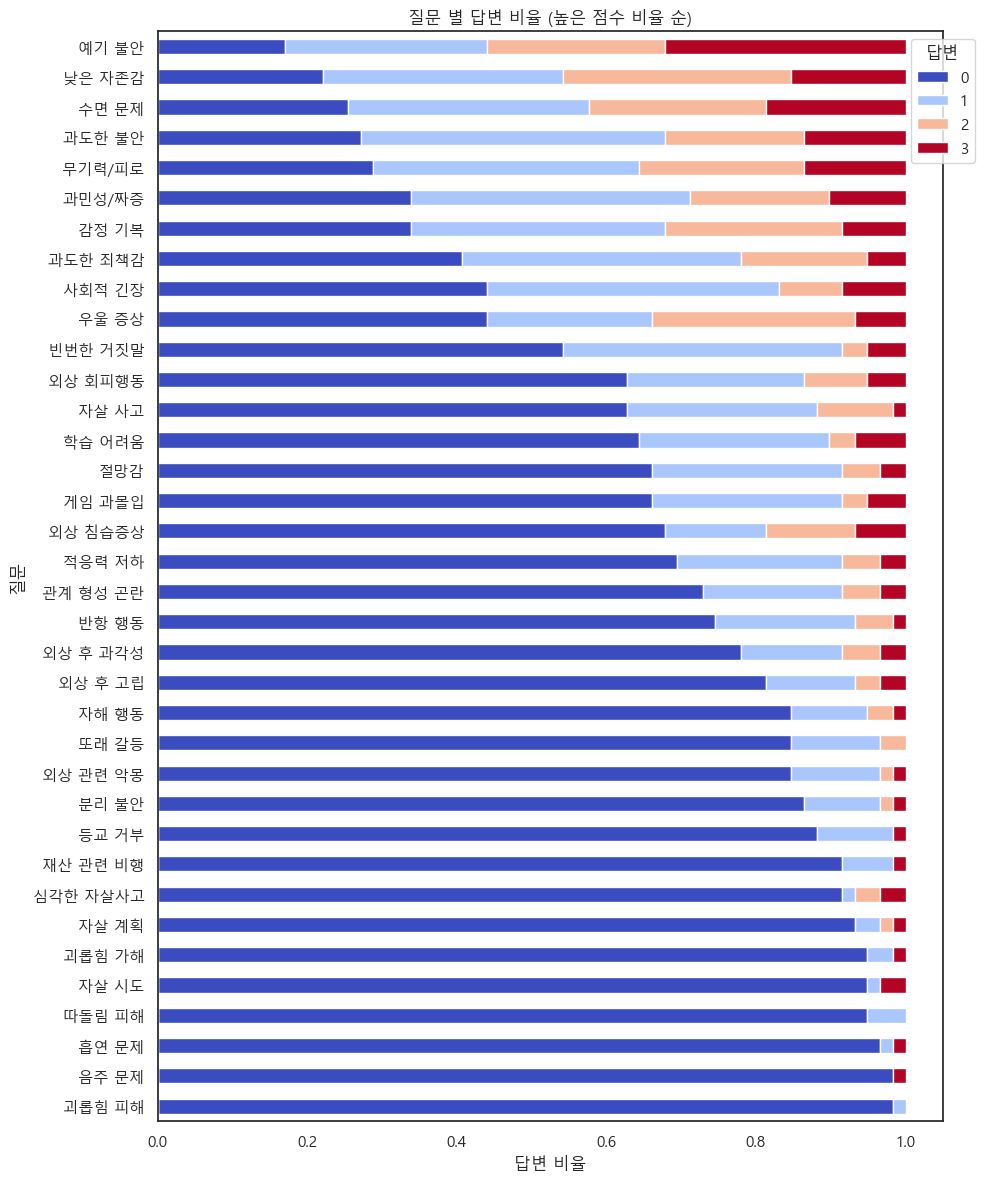

In [ ]:
pivot_df = question_df.pivot(
    index="student_id", columns="Question", values="Answer")

likert_counts = question_df.groupby("Question")["Answer"].value_counts(
    normalize=True).unstack(fill_value=0)

high_score_sum = likert_counts[[col for col in [
    3, 2, 1] if col in likert_counts.columns]].sum(axis=1)
likert_counts = likert_counts.loc[high_score_sum.sort_values(
    ascending=True).index]

likert_counts.plot(kind="barh", stacked=True,
                   colormap="coolwarm", figsize=(10, 12))
plt.title("질문 별 답변 비율 (높은 점수 비율 순)")
plt.xlabel("답변 비율")
plt.ylabel("질문")
plt.legend(title="답변", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

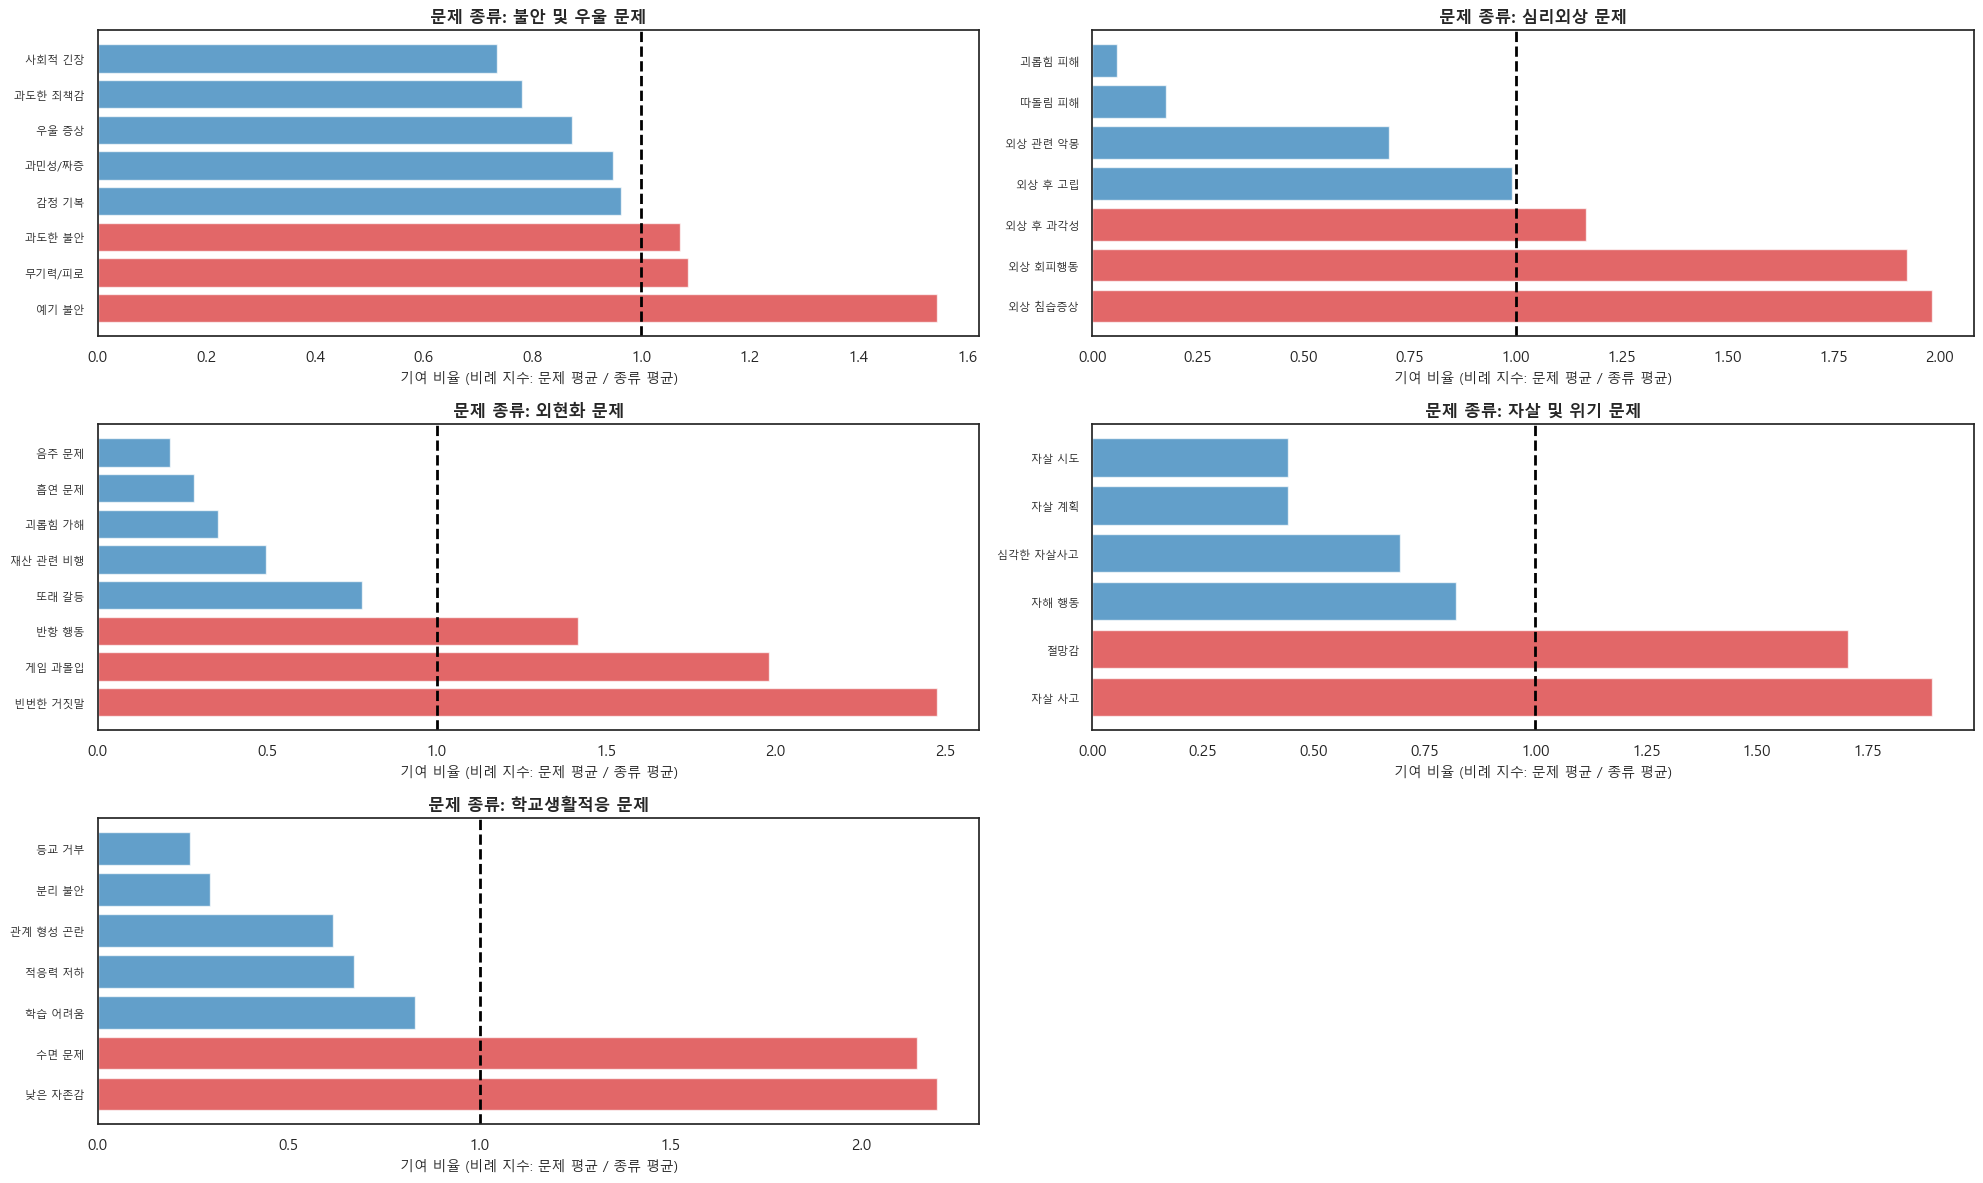

In [ ]:
import pandas as pd

# Step 1: Compute mean score per question
question_avg = question_df.groupby(['Type', 'Question'])[
    'Answer'].mean().reset_index(name='QuestionAvg')

# Step 2: Compute mean score per domain (Type)
domain_avg = question_df.groupby(
    'Type')['Answer'].mean().reset_index(name='DomainAvg')

# Step 3: Merge and compute contribution ratio
contrib_df = pd.merge(question_avg, domain_avg, on='Type')
contrib_df['ContributionRatio'] = contrib_df['QuestionAvg'] / \
    contrib_df['DomainAvg']

# Step 4: Sort
contrib_df = contrib_df.sort_values(
    ['Type', 'ContributionRatio'], ascending=[True, False])

types = contrib_df['Type'].unique()
n_types = len(types)

n_rows = int(np.ceil(n_types / 2))

fig, axes = plt.subplots(nrows=n_rows,
                         ncols=2,
                         figsize=(20, 4 * n_rows))

axes = axes.flatten() if n_types > 1 else [axes]

for idx, type_name in enumerate(types):
    ax = axes[idx]
    type_data = contrib_df[contrib_df['Type'] == type_name].sort_values(
        'ContributionRatio', ascending=False)

    colors = ['#d62728' if x >
              1 else '#1f77b4' for x in type_data['ContributionRatio']]

    ax.barh(type_data['Question'],
            type_data['ContributionRatio'], color=colors, alpha=0.7)
    ax.axvline(x=1, color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('기여 비율 (비례 지수: 문제 평균 / 종류 평균)', fontsize=10)
    ax.set_title(f'문제 종류: {type_name}', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelsize=8)

# Hide empty subplots if odd number of types
for idx in range(n_types, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

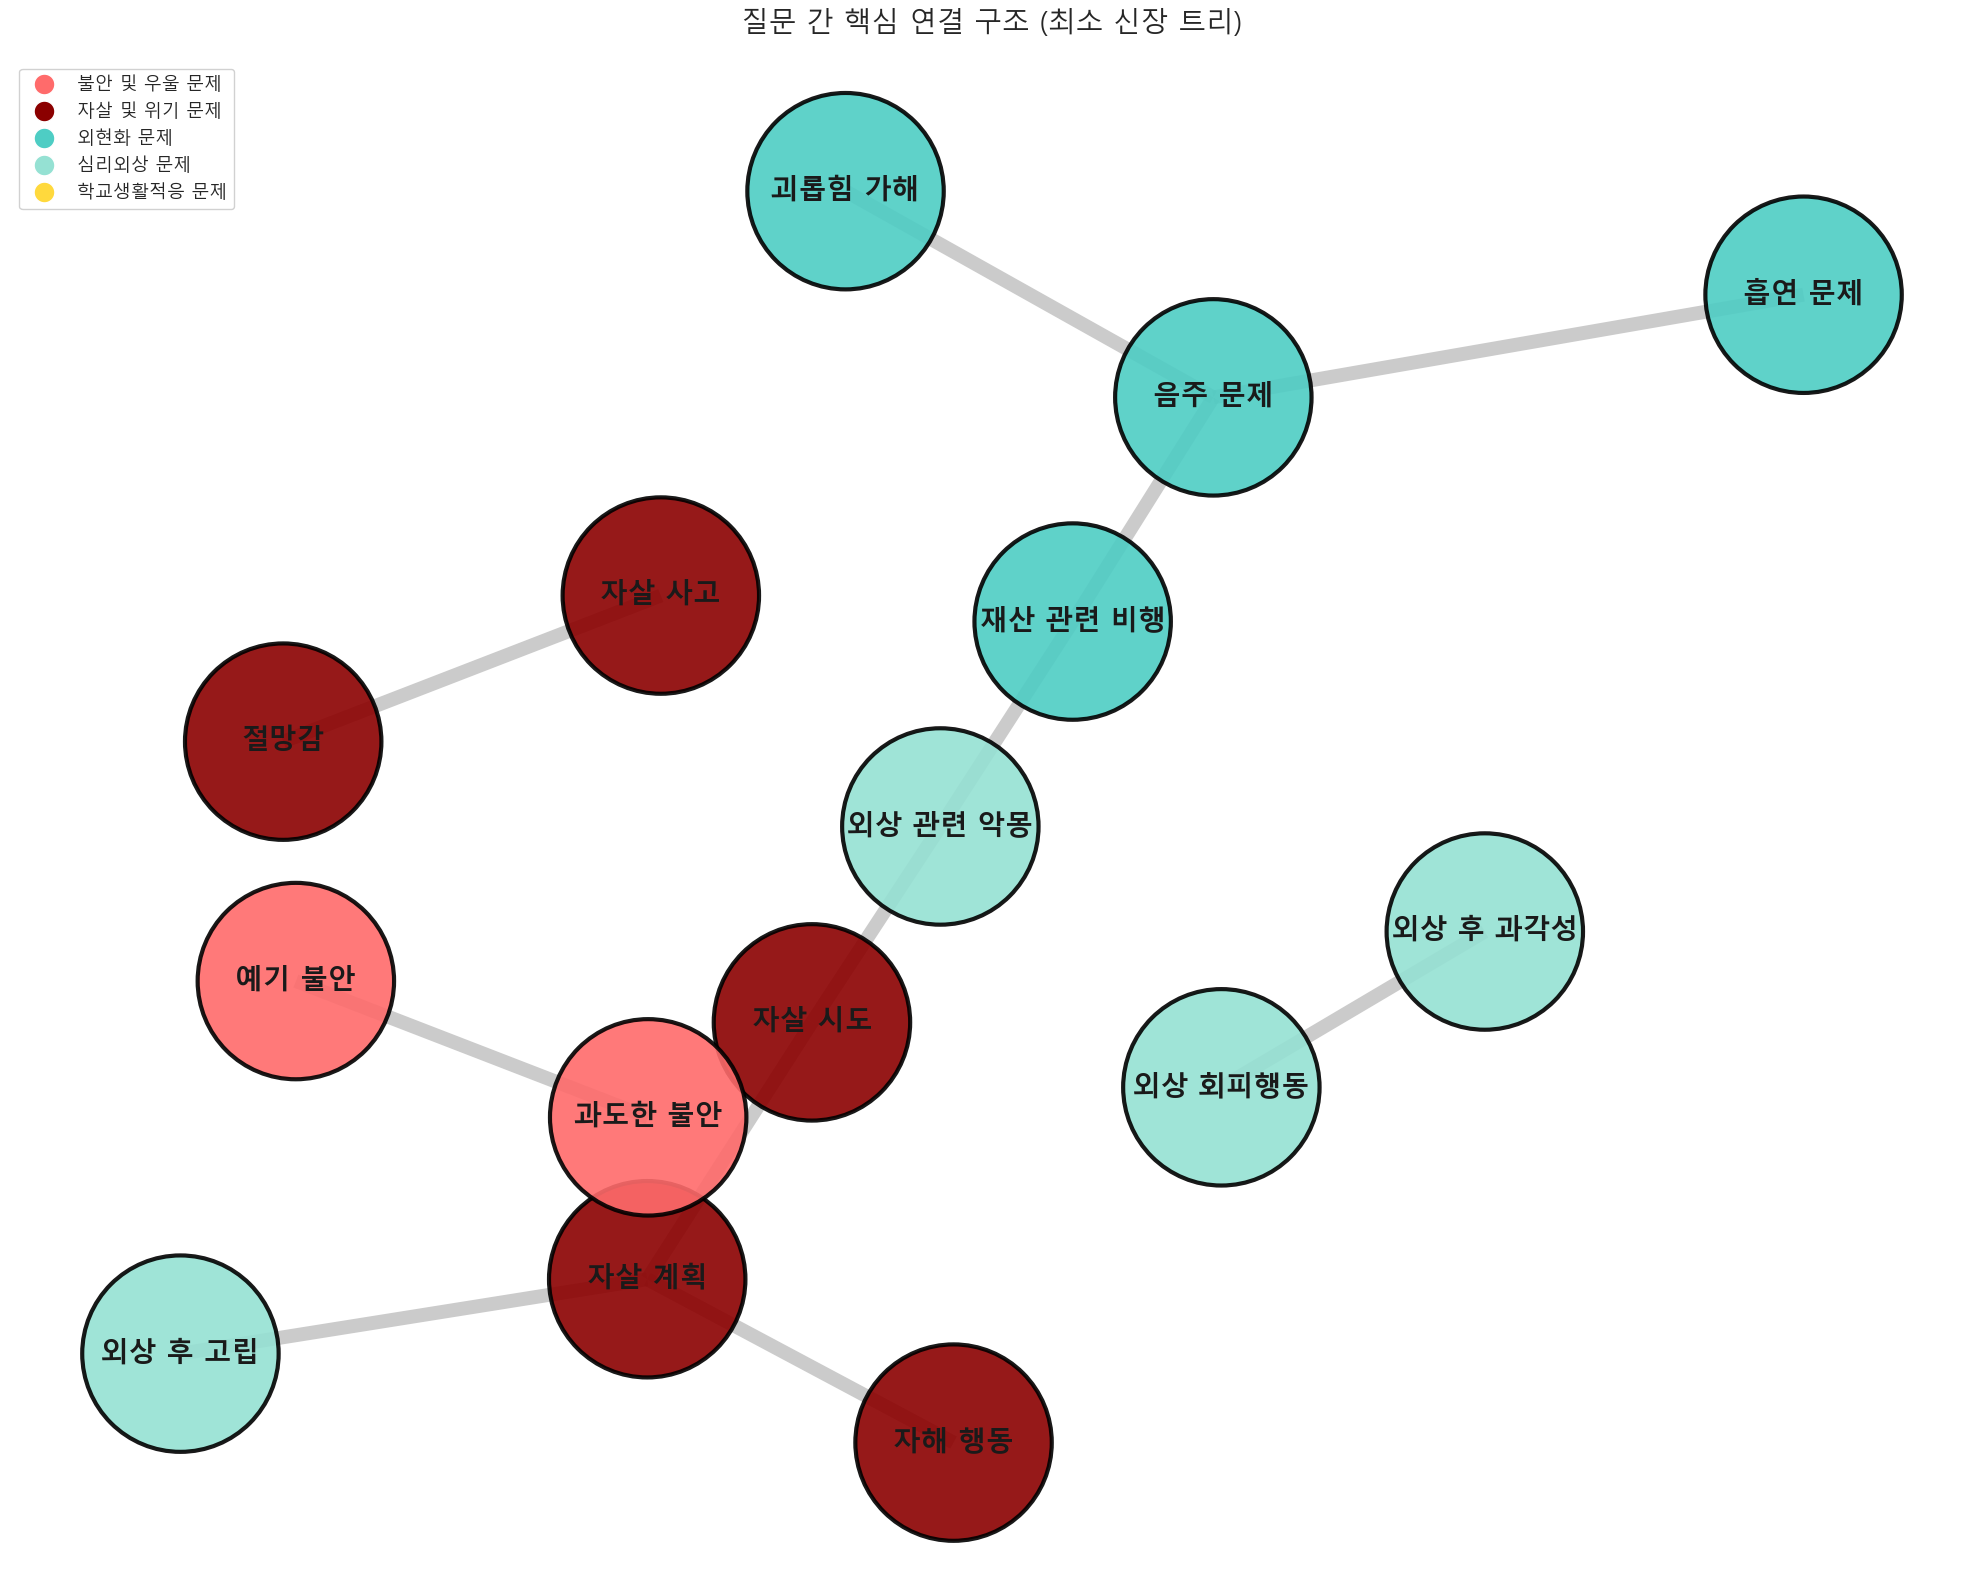


=== 최소 신장 트리: 15개 노드, 11개 엣지 ===


In [ ]:
# 방법 2: Minimum Spanning Tree (최소 신장 트리)
# 모든 노드를 연결하되 가장 중요한 연결만 유지

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 상위 30개의 강한 상관관계만 선택

corr_matrix = pivot_df.corr()

corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1.0]  # 자기 상관 제거
top_pairs = corr_pairs.head(30)

G = nx.Graph()

# Top 30 쌍만 엣지로 추가
for (q1, q2), corr_value in top_pairs.items():
    G.add_edge(q1, q2, weight=corr_value)

# Type 매핑 가져오기
type_mapping = question_df[['Question', 'Type']].drop_duplicates(
).set_index('Question')['Type'].to_dict()

# Type별 색상 지정
colors_map = {
    '불안 및 우울 문제': '#FF6B6B',
    '자살 및 위기 문제': '#8B0000',
    '외현화 문제': '#4ECDC4',
    '심리외상 문제': '#95E1D3',
    '학교생활적응 문제': '#FFD93D'
}

# 범례 요소 생성
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color, markersize=15, label=type_name)
                   for type_name, color in colors_map.items()]

# 가중치를 반전 (상관계수가 높을수록 거리가 가까움)
for u, v, data in G.edges(data=True):
    data['distance'] = 1 - data['weight']

# 최소 신장 트리 생성
mst = nx.minimum_spanning_tree(G, weight='distance')

plt.figure(figsize=(20, 16))
pos = nx.kamada_kawai_layout(mst)

node_colors = [colors_map.get(type_mapping.get(node, ''), 'lightgray')
               for node in mst.nodes()]

# MST는 트리 구조이므로 계층적으로 보기 좋음
nx.draw_networkx_edges(mst, pos, width=10, alpha=0.6, edge_color='darkgray')
nx.draw_networkx_nodes(mst, pos, node_color=node_colors,
                       node_size=20000, alpha=0.9, edgecolors='black', linewidths=3)
nx.draw_networkx_labels(mst, pos, font_family='Malgun Gothic',
                        font_size=20, font_weight='bold')

plt.legend(handles=legend_elements, loc='upper left', fontsize=13,
           prop={'family': 'Malgun Gothic', 'size': 13}, framealpha=0.9)

plt.title('질문 간 핵심 연결 구조 (최소 신장 트리)',
          fontsize=20, fontfamily='Malgun Gothic', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print(
    f"\n=== 최소 신장 트리: {mst.number_of_nodes()}개 노드, {mst.number_of_edges()}개 엣지 ===")